## Libraries

In [1]:
from shutil import copy
import base64
import random
import json
import zlib
import yaml
import io
import os

from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2

# Visualize dataset annotations

## Coco 2017 dataset

In [2]:
coco_config_yaml_path = r'D:\Code\Project\AI_projects\App_removing_objects\drafts\configs\coco128-seg.yaml'

with open(coco_config_yaml_path, 'r', encoding='utf-8') as flabel:
    fyaml = yaml.safe_load(flabel)
    names = fyaml['names']

In [3]:
colors = dict()
for name in names.keys():
    colors[name] = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

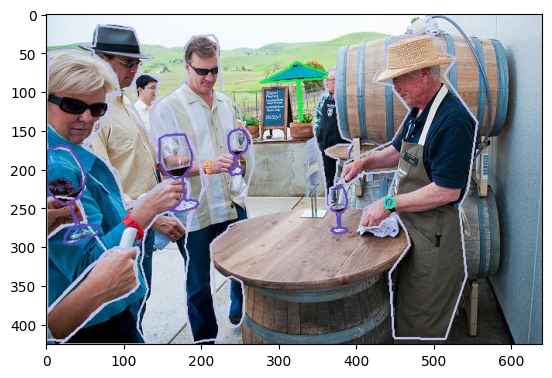

In [4]:
name = '000000000308'

images_path = fr'D:\Code\Project\AI_projects\App_removing_objects\drafts\dataset\Segmentation\coco128-seg\images\train2017\{name}.jpg'
annotation_path = fr'D:\Code\Project\AI_projects\App_removing_objects\drafts\dataset\Segmentation\coco128-seg\labels\train2017\{name}.txt'


with open(annotation_path, 'r') as fanno:
    img = cv2.imread(images_path)
    img_copy = img.copy()
    h, w, _ = img.shape
    for line in fanno:
        anno = line.strip().split(' ')
        label, points = anno[0], anno[1:]
        points = np.array(list(map(float, points)))
        points = points.reshape(-1, 2)
        points[:, 0] = (points[:, 0] * w).astype(int)
        points[:, 1] = (points[:, 1] * h).astype(int)
        
        cv2.polylines(img, [points.astype(int)], -1, colors[int(label)], 2)
        # cv2.fillPoly(img, [points.astype(int)], colors[int(label)])
        # cv2.addWeighted(img, 0.5, img_copy, 0.5, 0, img_copy)

plt.imshow(img[:, :, :: -1])

# Supervisely dataset
* Link: [Supervisely dataset](https://docs.supervise.ly/data-organization/00_ann_format_navi/04_supervisely_format_objects)

## Functions

In [2]:
from imantics import Mask

def poly_area(points):
    return 0.5 * np.abs(np.dot(points[:, 0], np.roll(points[:, 1], 1))\
            - np.dot(points[:, 1], np.roll(points[:, 0], 1)))

def base64_2_mask(s):
    z = zlib.decompress(base64.b64decode(s))
    n = np.frombuffer(z, np.uint8)
    mask = cv2.imdecode(n, cv2.IMREAD_UNCHANGED)[:, :, 3].astype(bool)
    return mask

def mask_2_base64(mask):
    img_pil = Image.fromarray(np.array(mask, dtype=np.uint8))
    img_pil.putpalette([0,0,0,255,255,255])
    bytes_io = io.BytesIO()
    img_pil.save(bytes_io, format='PNG', transparency=0, optimize=0)
    bytes = bytes_io.getvalue()
    return base64.b64encode(zlib.compress(bytes)).decode('utf-8')

def origin_2_xyxy(points, height, width):
    xmin, ymin = points
    xmax, ymax = xmin + width, ymin + height
    return xmin, ymin, xmax, ymax

def mask_2_polygons(mask):
    polygons = Mask(mask).polygons()
    max_dict = dict()
    for poly in polygons.points:
        area = poly_area(poly)
        max_dict[area] = poly
    idx = max(max_dict)
    return max_dict[idx]

def point_2_str(points, height, width):
    str_point = ''
    for point in points:
        str_point = str_point + f'{point[0] / width} {point[1] / height} '
    return str_point.rstrip()

## Visualize

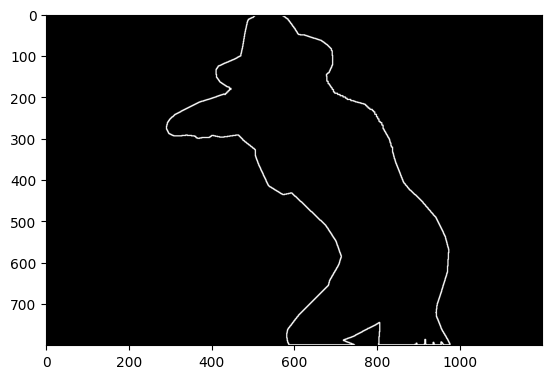

In [7]:
num = 'ds1'
supervise_path = f'D:/Code/Project/AI_projects/App_removing_objects/drafts/dataset/Segmentation/Supervisely_Person_Dataset/Supervisely_Person_Dataset/{num}'

test_file = 'pexels-photo-206470.png'
img_path = f'{supervise_path}/img/{test_file}'
ann_path = f'{supervise_path}/ann/{test_file}.json'

with open(ann_path, 'r') as f:
    img = cv2.imread(img_path)
    h, w, _ = img.shape
    tmp_mask = np.zeros(img.shape)
    json_load = json.load(f)

    meta = json_load['objects'][0]
    if meta['geometryType'] == 'bitmap':
        bitmap = meta['bitmap']
        data  = bitmap['data']
        origin = bitmap['origin']
        
        mask_tmp = base64_2_mask(data)
        h_tmp, w_tmp = mask_tmp.shape[:2]
        xmin, ymin, xmax, ymax = origin_2_xyxy(origin, h_tmp, w_tmp)
        mask = np.zeros((h, w))
        tmp_mask = np.zeros((h, w))

        mask[ymin:ymax, xmin:xmax] = mask_tmp
        poly_points = mask_2_polygons(mask)
        cv2.polylines(tmp_mask, [poly_points], -1, (255, 255, 255), 2)
        plt.imshow(tmp_mask, cmap='gray')

    elif meta['geometryType'] == 'polygon':
        poly_points = meta['points']['exterior']
        tmp_mask = np.zeros((h, w))
        cv2.polylines(tmp_mask, [np.array(poly_points)], -1, (255, 255, 255), 2)
        plt.imshow(tmp_mask, cmap='gray')

# Convert supervisely to yolov8 format

In [57]:
import os

supervise_path = f'D:/Code/Project/AI_projects/App_removing_objects/drafts/dataset/Segmentation/Supervisely_Person_Dataset/Supervisely_Person_Dataset'
ann_txt = 'D:/Code/Project/AI_projects/App_removing_objects/drafts/dataset/Segmentation/Supervisely_Person_Dataset/labels.txt'

with open(ann_txt, 'w') as anno:
    for i in tqdm(range(1, 14)):
        num = f'ds{i}'
        path = f'{supervise_path}/{num}/ann'
        
        for root, _, ann_json in os.walk(path):
            for ann in ann_json:
                with open(os.path.join(root, ann), 'r') as f:
                    meta = json.load(f)
                    height = meta['size']['height']
                    width = meta['size']['width']

                    objects = meta['objects']
                    for obj in objects:
                        if obj['geometryType'] == 'bitmap':
                            bitmap = obj['bitmap']
                            data  = bitmap['data']
                            origin = bitmap['origin']
                            
                            mask_tmp = base64_2_mask(data)
                            h_tmp, w_tmp = mask_tmp.shape[:2]
                            xmin, ymin, xmax, ymax = origin_2_xyxy(origin, h_tmp, w_tmp)
                            mask = np.zeros((height, width))

                            mask[ymin:ymax, xmin:xmax] = mask_tmp
                            poly_points = mask_2_polygons(mask)
                            
                        elif obj['geometryType'] == 'polygon':
                            poly_points = obj['points']['exterior']
                    
                        str_p = point_2_str(poly_points, height, width)
                        anno.write(f'0\t{num}/img/{ann[:-5]}\t{str_p}\n')
                    

100%|██████████| 13/13 [00:22<00:00,  1.71s/it]


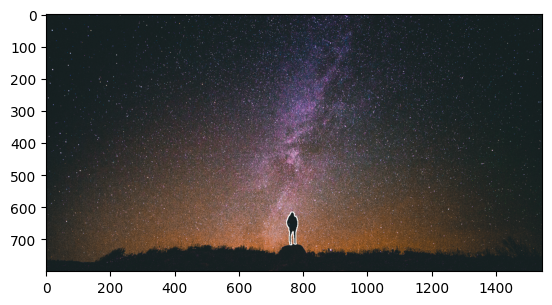

In [67]:
with open(ann_txt, 'r') as anno:
    for line in anno:
        line = line.strip()
        c, name, points = line.split('\t')
        points = np.array(list(map(float, points.split(' '))))

        img = cv2.imread(os.path.join('D:/Code/Project/AI_projects/App_removing_objects/drafts/dataset/Segmentation/Supervisely_Person_Dataset/Supervisely_Person_Dataset', name))
        h, w = img.shape[:2]
        points = points.reshape(-1, 2)
        points[:, 0] = (points[:, 0] * w).astype(int)
        points[:, 1] = (points[:, 1] * h).astype(int)
        cv2.polylines(img, [points.astype(int)], -1, (255, 255, 255), 2)
        break

plt.imshow(img[:, :, :: -1])

# Train - Val - Test

In [14]:
def split_data(image_file, root, save, mode):
    root_annotation = os.path.join(root[:-3], 'ann')

    os.makedirs(os.path.join(save, mode, 'labels'), exist_ok=True)
    os.makedirs(os.path.join(save, mode, 'images'), exist_ok=True)

    for image in image_file:
        name = image.split('.')[0]
        annotation_file = image + '.json'

        # Copy image
        copy(os.path.join(root, image),
             os.path.join(save, mode, 'images', image))
        
        with open(os.path.join(root_annotation, annotation_file), 'r') as f:
            meta = json.load(f)
            height = meta['size']['height']
            width = meta['size']['width']

            objects = meta['objects']
            with open(os.path.join(save, mode, 'labels', f'{name}.txt'), 'w') as label_txt:
                for obj in objects:
                    if obj['geometryType'] == 'bitmap':
                        bitmap = obj['bitmap']
                        data  = bitmap['data']
                        origin = bitmap['origin']
                        
                        mask_tmp = base64_2_mask(data)
                        h_tmp, w_tmp = mask_tmp.shape[:2]
                        xmin, ymin, xmax, ymax = origin_2_xyxy(origin, h_tmp, w_tmp)
                        mask = np.zeros((height, width))

                        mask[ymin:ymax, xmin:xmax] = mask_tmp
                        poly_points = mask_2_polygons(mask)
                        
                    elif obj['geometryType'] == 'polygon':
                        poly_points = obj['points']['exterior']
                
                    str_p = point_2_str(poly_points, height, width)
                    label_txt.write(f'0 {str_p}\n')

In [15]:
np.random.seed(42)

train_ratio = 0.7
val_ratio = 0.2
test_ratio = train_ratio - val_ratio

save = 'D:/Code/Project/AI_projects/App_removing_objects/drafts/dataset/Segmentation/Supervisely_Person_Dataset/supervisely_dataset'
root = 'D:/Code/Project/AI_projects/App_removing_objects/drafts/dataset/Segmentation/Supervisely_Person_Dataset/Supervisely_Person_Dataset'

for i in tqdm(range(1, 14)):
    num = f'ds{i}'
    path = f'{root}/{num}/img'
    imgs = os.listdir(path)

    np.random.shuffle(ann_json)

    total = len(imgs)
    total_train = int(total * train_ratio)
    total_val = int(total * val_ratio)
    total_test = int(total * test_ratio)

    train = imgs[ : total_train]
    val = imgs[total_train : total_train + total_val]
    test = imgs[total_train + total_val : total]
    
    print(f'{num}=============================')
    split_data(train, path + f'', save, 'train')
    split_data(val, path, save, 'val')
    split_data(test, path, save, 'test')
            

ds1=============================


test: 100%|██████████| 38/38 [00:02<00:00, 17.85it/s]


ds2=============================


test: 100%|██████████| 70/70 [00:03<00:00, 18.95it/s]


ds3=============================


test: 100%|██████████| 8/8 [00:00<00:00, 20.70it/s]


ds4=============================


test: 100%|██████████| 7/7 [00:00<00:00, 23.46it/s]


ds5=============================


test: 100%|██████████| 14/14 [00:00<00:00, 19.82it/s]


ds6=============================


test: 100%|██████████| 200/200 [00:04<00:00, 46.58it/s]


ds7=============================


test: 100%|██████████| 54/54 [00:06<00:00,  8.16it/s]


ds8=============================


test: 100%|██████████| 142/142 [00:09<00:00, 15.31it/s]


ds9=============================


test: 100%|██████████| 14/14 [00:01<00:00, 11.75it/s]


ds10=============================


test: 100%|██████████| 4/4 [00:00<00:00, 12.14it/s]


ds11=============================


test: 100%|██████████| 24/24 [00:01<00:00, 15.36it/s]


ds12=============================


test: 100%|██████████| 4/4 [00:00<00:00, 12.71it/s]


ds13=============================


test: 100%|██████████| 4/4 [00:00<00:00, 14.26it/s]
